## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = data_path + 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = data_path + 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = data_path + 'uniprotdomains.gz'
gene_domain_file_path = data_path + 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
epi25_variants_file_path = data_path + 'epi25_variant_results.tsv.gz'
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'
ukb_variants_file_path = data_path + 'ukb24310_c19.qced_nonrel.vmiss.gz'

## Define helper methods

In [4]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Load data

In [5]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [6]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [7]:
# Read the data into a DataFrame
epi25_variant_results_df = pd.read_csv(epi25_variants_file_path, sep='\t')

# Split locus into chr and pos and convert to integers
epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# Filter out rows
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
                                                    (epi25_variant_results_df['consequence'] != "non_coding") & 
                                                    (epi25_variant_results_df['consequence'] != "NA")]

# Add gene names
epi25_variant_results_df = pd.merge(epi25_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

epi25_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,mpc,polyphen,group,variant_id,...,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,chr,pos,gene_name
0,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,EPI,chr1:69731:T:C,...,37174,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
1,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,NAFE,chr1:69731:T:C,...,16300,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
2,chr1:69923,"[""T"",""G""]",ENSG00000186092,other_missense,c.833T>G,p.Ile278Ser,2.3070,benign,EPI,chr1:69923:T:G,...,30002,0,43218,NaN,NaN,NaN,True,chr1,69923,OR4F5
3,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,EPI,chr1:69928:T:A,...,30156,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
4,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,NAFE,chr1:69928:T:A,...,13296,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11716909,chr22:50782272,"[""G"",""A""]",ENSG00000079974,other_missense,c.23C>T,p.Pro8Leu,NaN,benign,NAFE,chr22:50782272:G:A,...,18438,1,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716910,chr22:50782272,"[""G"",""T""]",ENSG00000079974,other_missense,c.23C>A,p.Pro8Gln,NaN,benign,EPI,chr22:50782272:G:T,...,41956,0,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716911,chr22:50782285,"[""C"",""T""]",ENSG00000079974,other_missense,c.10G>A,p.Asp4Asn,NaN,benign,EPI,chr22:50782285:C:T,...,41954,0,64092,NaN,NaN,NaN,NaN,chr22,50782285,RABL2B
11716912,chr22:50782286,"[""T"",""G""]",ENSG00000079974,other_missense,c.9A>C,p.Glu3Asp,NaN,benign,EPI,chr22:50782286:T:G,...,41954,0,64054,NaN,NaN,NaN,NaN,chr22,50782286,RABL2B


In [26]:
# Define path to predictions file
rgc_predictions_file_path = results_path + 'HMM_rgc_0.9_over20_chr2_predictions_rgc_wgs.tsv.gz'

# Load in saved predictions for rgc dataset
predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Compare predictions on RGC to Epi25 dataset

In [18]:
# Parameters for analysis
prob_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = epi25_variant_results_df
# predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_predictions_df = predictions_df[(predictions_df['chr'] == 'chr' + str(chromnum)) & 
                                        (predictions_df['prob_0'] >= prob_thr)]
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]
    
    # Filter variant results for positions over probability threshold
    cases_df = pd.merge(chr_predictions_df['pos'],
                        chr_variant_results_df, on='pos')

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(results_path + 'epi_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 2
               gene_id gene_name group  total_ac_case  total_an_case  \
17120  ENSG00000144285     SCN1A   DEE              6           3876   
17121  ENSG00000144285     SCN1A   EPI             13          41958   

       total_ac_ctrl  total_an_ctrl  odds_ratio       p_value  
17120              0          66888         inf  2.690537e-08  
17121              0          66888         inf  4.145088e-06  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 3
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, tota

,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
0,ENSG00000117480,FAAH,NAFE,5,18438,0,66888,inf,0.000471
1,ENSG00000117480,FAAH,DEE,2,3876,0,66888,inf,0.002999
2,ENSG00000088035,ALG6,DEE,2,3876,0,66884,inf,0.003000
3,ENSG00000009724,MASP2,DEE,2,3876,1,66882,34.528136,0.008671
4,ENSG00000131697,NPHP4,NAFE,4,18420,1,66866,14.523241,0.008998
...,...,...,...,...,...,...,...,...,...
22373,ENSG00000221963,APOL6,DEE,0,3876,1,66888,0.000000,1.000000
22374,ENSG00000100220,RTCB,NAFE,0,18438,2,66884,0.000000,1.000000
22375,ENSG00000100220,RTCB,DEE,0,3876,2,66884,0.000000,1.000000
22376,ENSG00000128313,APOL5,DEE,0,3876,1,66888,0.000000,1.000000


In [28]:
# Parameters for analysis
prob_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = epi25_variant_results_df
# predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

filtered_predictions_df = predictions_df[(predictions_df['prob_0'] >= prob_thr)]

variant_results_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                        (variant_results_df['an_case'] > 0) & 
                                        (variant_results_df['an_ctrl'] > 0)]

# Filter variant results for positions over probability threshold
cases_df = pd.merge(filtered_predictions_df, variant_results_df, on=['chr', 'pos'])

# Apply fishers exact test to get signicance scores from cases data
tested_df = apply_fishers_exact_test(cases_df)

# Filter rows where p_value < significance threshold and append these rows to the DataFrame
significant_genes_df = tested_df[tested_df['p_value'] <= significance_thr]

# Display the sorted DataFrame
# print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
# significant_genes_df.to_csv(results_path + 'epi_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

significant_genes_df #[significant_genes_df['p_value'] < .0001]

,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
59284,ENSG00000144285,SCN1A,DEE,6,3876,0,66888,inf,2.690537e-08
59285,ENSG00000144285,SCN1A,EPI,13,41958,0,66888,inf,4.145088e-06
365351,ENSG00000100150,DEPDC5,EPI,10,41958,0,66888,inf,7.239970e-05
365355,ENSG00000100150,DEPDC5,NAFE,6,18438,0,66888,inf,1.017460e-04
133144,ENSG00000197283,SYNGAP1,DEE,3,3876,0,66888,inf,1.642088e-04
...,...,...,...,...,...,...,...,...,...
66187,ENSG00000118260,CREB1,DEE,0,3876,1,66812,0.000000,1.000000e+00
65925,ENSG00000204186,ZDBF2,EPI,3,41958,4,66888,1.195638,1.000000e+00
65924,ENSG00000204186,ZDBF2,DEE,0,3876,4,66888,0.000000,1.000000e+00
191984,ENSG00000188566,NDOR1,DEE,0,3876,1,66888,0.000000,1.000000e+00


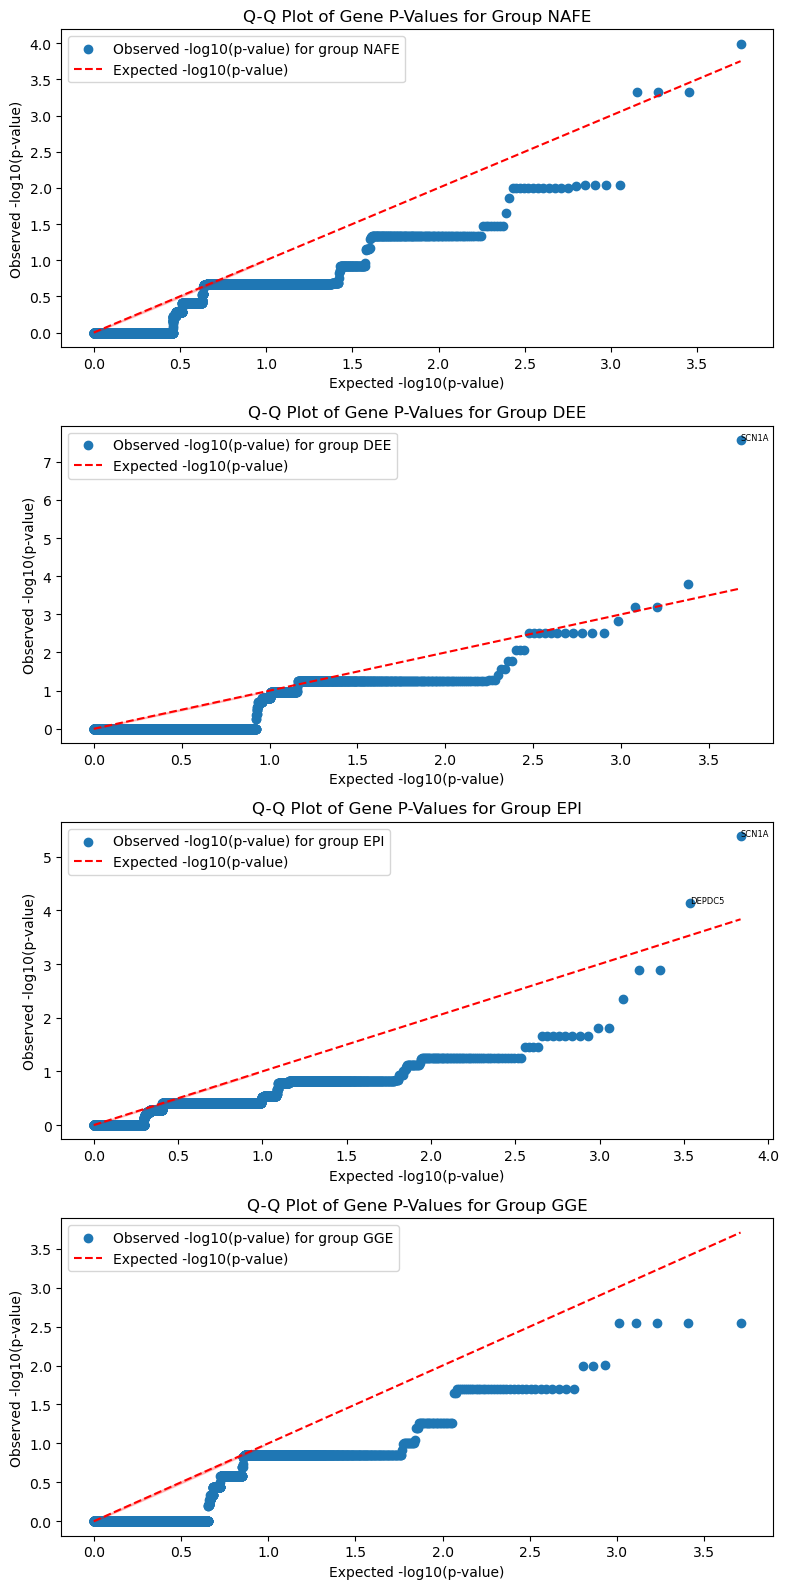

In [19]:
plot_group_QQ(significant_genes_df)

## Combine with Alpha Missense Predictions

In [20]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
epi25_variants_filtered_df = epi25_variant_results_df[(epi25_variant_results_df['ac_ctrl'] + epi25_variant_results_df['ac_case'] <= cnt_thr) &
                                                       (epi25_variant_results_df['an_case'] > 0) &
                                                       (epi25_variant_results_df['an_ctrl'] > 0)
                                                      ].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "variant_id", "estimate", "chi_sq_stat", "in_analysis"])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), epi25_variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(results_path + "constraint_am_epi25_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity,gene_id,consequence,group,ac_case,an_case,ac_ctrl,an_ctrl,p_value,gene_name,effect_size,var_effect_size
0,chr1,925946,0.000050,0.999950,1.0,0.9876,ENSG00000187634,damaging_missense,DEE,0,3876,1,66886,NaN,SAMD11,1.749437,2.666940
1,chr1,925946,0.000050,0.999950,1.0,0.9876,ENSG00000187634,damaging_missense,EPI,0,41956,1,66886,NaN,SAMD11,-0.632263,2.666705
2,chr1,925946,0.000050,0.999950,1.0,0.9876,ENSG00000187634,damaging_missense,GGE,0,10996,1,66886,NaN,SAMD11,0.706793,2.666773
3,chr1,925946,0.000050,0.999950,1.0,0.9876,ENSG00000187634,damaging_missense,NAFE,0,18438,1,66886,NaN,SAMD11,0.189929,2.666736
4,chr1,925948,0.000040,0.999960,1.0,0.9460,ENSG00000187634,damaging_missense,EPI,2,41958,0,66886,NaN,SAMD11,2.075802,2.400039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142394,chr22,50777959,0.391475,0.608525,0.0,0.4255,ENSG00000079974,damaging_missense,NAFE,0,18438,1,66888,NaN,RABL2B,0.189959,2.666736
9142395,chr22,50777974,0.010142,0.989858,0.0,0.9569,ENSG00000079974,damaging_missense,DEE,0,3876,1,66888,NaN,RABL2B,1.749467,2.666940
9142396,chr22,50777974,0.010142,0.989858,0.0,0.9569,ENSG00000079974,damaging_missense,EPI,0,41958,1,66888,NaN,RABL2B,-0.632281,2.666705
9142397,chr22,50777974,0.010142,0.989858,0.0,0.9569,ENSG00000079974,damaging_missense,GGE,0,10998,1,66888,NaN,RABL2B,0.706641,2.666773


In [21]:
# Read the data from the file
merged_df = pd.read_csv(results_path + 'constraint_am_epi25_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[merged_df['consequence'] != "pLoF"]

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = np.log(gene_data['effect_size'])
    weights = 1 / np.sqrt(gene_data['var_effect_size'])

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
epi_p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
epi_p_values_df.to_csv(results_path + "constraint_am_epi25_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
epi_p_values_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 70918/71682 [04:58<00:03, 237.93gene/s]


,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall
0,ENSG00000000419,DPM1,DEE,0.782645,0.025735,5.409458e-03,0.069863
1,ENSG00000000419,DPM1,EPI,0.265031,0.215706,1.071627e-01,0.303342
2,ENSG00000000419,DPM1,GGE,0.932055,0.654034,5.166753e-01,0.903309
3,ENSG00000000419,DPM1,NAFE,0.308228,0.203592,3.472101e-02,0.238369
4,ENSG00000000457,SCYL3,DEE,0.705142,0.421837,3.788741e-17,0.622045
...,...,...,...,...,...,...,...
70723,ENSG00000285982,ENSG00000285982,NAFE,0.982666,0.297393,8.409360e-01,0.569237
70724,ENSG00000285991,ENSG00000285991,DEE,0.077704,0.046611,2.243240e-03,0.028075
70725,ENSG00000285991,ENSG00000285991,EPI,0.558143,0.524133,6.173421e-01,0.653124
70726,ENSG00000285991,ENSG00000285991,GGE,0.917521,0.223830,9.594972e-01,0.453687


In [29]:
epi_significant_genes_df = pd.read_csv(results_path + 'epi_rgc_constraint_pvalues.tsv.gz', sep='\t')
epi_p_values_df = pd.read_csv(results_path + 'constraint_am_epi25_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(epi_p_values_df, epi_significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

# joined_p_values_df[joined_p_values_df['p_value_overall'] < joined_p_values_df['p_value']]
joined_p_values_df[['gene_id', 'gene_name', 'group', 'p_value_prob_0', 'p_value_am_pathogenicity', 'p_value_overall', 'p_value', 'p_comb']]

,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_overall,p_value,p_comb
0,ENSG00000000419,DPM1,DEE,0.782645,0.025735,0.069863,NaN,0.069863
1,ENSG00000000419,DPM1,EPI,0.265031,0.215706,0.303342,NaN,0.303342
2,ENSG00000000419,DPM1,GGE,0.932055,0.654034,0.903309,NaN,0.903309
3,ENSG00000000419,DPM1,NAFE,0.308228,0.203592,0.238369,NaN,0.238369
4,ENSG00000000457,SCYL3,DEE,0.705142,0.421837,0.622045,NaN,0.622045
...,...,...,...,...,...,...,...,...
71207,ENSG00000285762,NaN,EPI,NaN,NaN,NaN,1.0,1.000000
71208,ENSG00000285762,NaN,GGE,NaN,NaN,NaN,1.0,1.000000
71209,ENSG00000169548,ZNF280A,NAFE,NaN,NaN,NaN,1.0,1.000000
71210,ENSG00000169548,ZNF280A,EPI,NaN,NaN,NaN,1.0,1.000000


In [23]:
p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

# p_values_df = joined_p_values_df
# filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_overall'] < 1e-4)
filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_prob_0'] < 1e-4)

gene_name_mask = (p_values_df['gene_name'] == 'SLC2A1')
pd.set_option('display.max_rows', 200)
p_values_df[filter_mask].sort_values('p_comb')

,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall,p_value,p_comb
36529,ENSG00000155657,TTN,EPI,1.042177e-19,9.321278e-01,9.737494e-01,1.166642e-18,7.289862e-01,0.000000e+00
49999,ENSG00000174021,GNG5,EPI,3.753826e-15,3.075014e-16,4.075876e-16,4.186116e-16,NaN,4.186116e-16
36528,ENSG00000155657,TTN,DEE,4.238746e-18,8.495357e-01,0.000000e+00,4.563347e-17,1.000000e+00,1.776357e-15
46940,ENSG00000170180,GYPA,NAFE,1.822742e-13,4.615872e-01,5.782684e-16,3.576146e-14,NaN,3.576146e-14
70379,ENSG00000284512,ENSG00000284512,NAFE,1.143259e-14,6.966979e-13,5.206164e-15,2.107484e-12,NaN,2.107484e-12
58523,ENSG00000187733,AMY1C,EPI,2.295953e-12,2.327033e-12,4.030268e-12,3.553743e-12,NaN,3.553743e-12
31672,ENSG00000144285,SCN1A,DEE,5.366994e-05,7.413797e-02,3.965926e-14,5.868708e-06,2.690537e-08,4.812262e-12
70376,ENSG00000284512,ENSG00000284512,DEE,2.315791e-14,9.749044e-13,1.050428e-14,1.314411e-11,NaN,1.314411e-11
70378,ENSG00000284512,ENSG00000284512,GGE,9.224050e-14,6.216511e-12,4.203983e-14,1.324782e-11,NaN,1.324782e-11
17439,ENSG00000117407,ARTN,NAFE,2.636347e-11,7.777918e-02,8.470551e-13,5.486602e-11,NaN,5.486602e-11


## Compare against published results

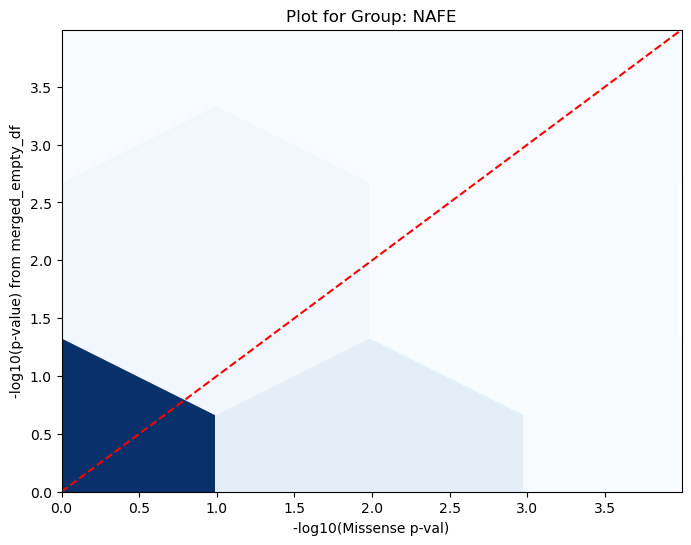

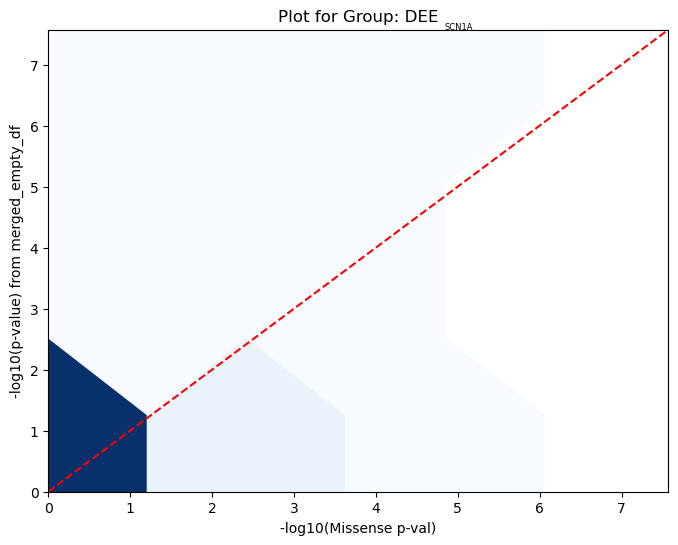

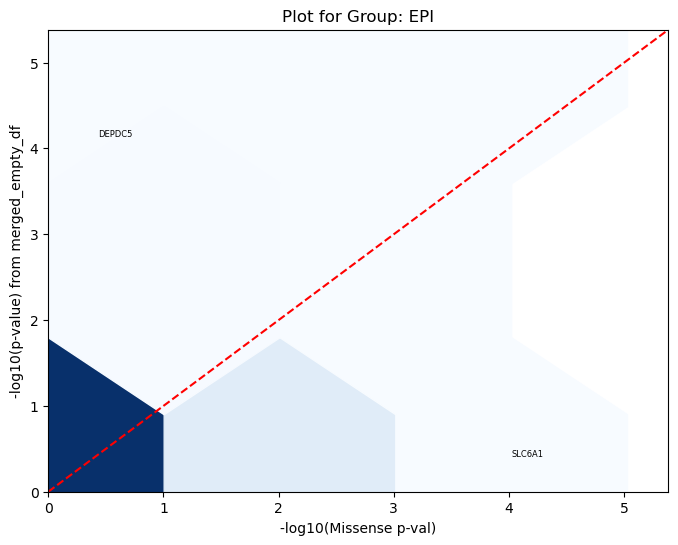

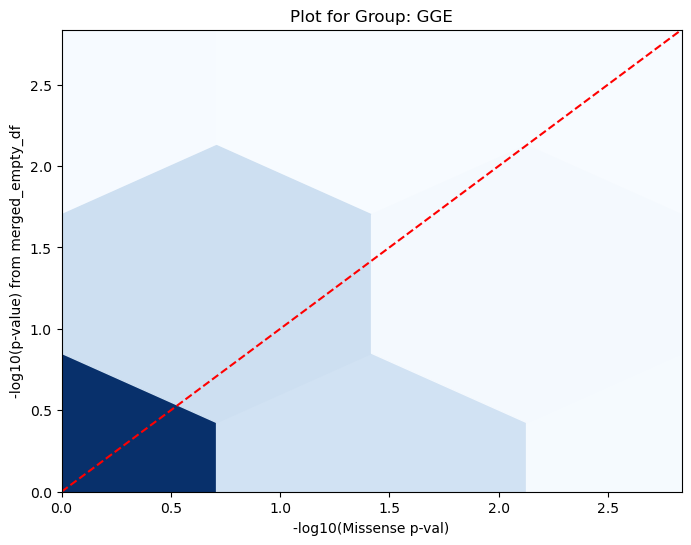

In [24]:
for group in significant_genes_df['group'].unique():
    file_pattern = data_path + f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Damaging Missense p‑val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")

## GeneBass exomes revisted

In [85]:
mrp_df = pd.read_csv(results_path + 'HMM_wgs_constraint_predictions.tsv.gz', sep='\t')

#Read in files, process, generate map file and then run MRP from Jupyter 
prop_thr = 0.6
gb_path = "Epilepsy_custom.genebass.tsv.gz"
gb_df = pd.read_csv(gb_path, sep='\t', compression='gzip')
print(gb_df.shape)
gb_filtered_df = gb_df[~gb_df['annotation'].isin(['LC', 'NA', 'synonymous']) & (gb_df['AC'] <= 5)]
#gb_filtered_df = gb_df[~gb_df['annotation'].isin(['LC', 'NA', 'synonymous']) ]
print(gb_filtered_df.shape)
# Processing 'locus' to get '#CHROM' and 'POS'
gb_filtered_df['#CHROM'] = gb_filtered_df['locus'].apply(lambda x: x.split(':')[0].replace('chr', ''))
gb_filtered_df['#CHROM'] = gb_filtered_df["#CHROM"].astype(str)
gb_filtered_df['POS'] = gb_filtered_df['locus'].apply(lambda x: x.split(':')[1])
# Convert to string if necessary (adjust as per your data types)
gb_filtered_df['POS'] = gb_filtered_df['POS'].astype(str)
mrp_df['pos'] = mrp_df['pos'].astype(str)
mrp_df['chr'] = mrp_df['chr'].astype(str)
# Merging DataFrames
#print(mrp_df[(mrp_df['chr'] == "17") & (mrp_df['pos'] == "7885025")])
value_counts = mrp_df['chr'].value_counts()
print(value_counts)
gb_filtered_df = pd.merge(gb_filtered_df, mrp_df, left_on=['#CHROM', 'POS'], right_on=['chr', 'pos'])
print(gb_filtered_df[(gb_filtered_df['#CHROM'] == "17") & (gb_filtered_df['POS'] == "7885025")])
gb_filtered_df = gb_filtered_df[gb_filtered_df['prob_0'] >= prop_thr]
#print(gb_filtered_df.shape)
# Processing 'markerID' to get 'REF' and 'ALT'
gb_filtered_df['REF'] = gb_filtered_df['markerID'].apply(lambda x: x.split('_')[1].split('/')[0])
gb_filtered_df['ALT'] = gb_filtered_df['markerID'].apply(lambda x: x.split('_')[1].split('/')[1])
gb_filtered_df['V'] = gb_filtered_df['#CHROM'] + ':' + gb_filtered_df['POS'] + ':' + gb_filtered_df['REF'] + ':' + gb_filtered_df['ALT']
meta_var_df = gb_filtered_df[['V', 'gene', 'annotation', 'AF']].copy()
meta_var_df['ld_indep'] = True
meta_var_df['pLI'] = "NA"
meta_var_df['MPC'] = "NA"
meta_var_df.rename(columns={
    'V': 'V',
    'gene': 'gene_symbol',
    'annotation': 'most_severe_consequence',
    'AF': 'maf'
}, inplace=True)

gb_filtered_df['P'] = gb_filtered_df["Pvalue"]
# Keeping 'BETA', 'SE', and 'Pvalue'
gb_filtered_df = gb_filtered_df[['#CHROM', 'POS', 'REF', 'ALT', 'BETA', 'SE', 'P']]
fileout = gb_path.split('.')[0] + "_sumstat.tsv.gz"
gb_filtered_df.to_csv(fileout, sep='\t', index=False, compression='gzip')

fileout_pre = fileout.split('.')[0]  # Replace with the actual prefix
map_file_name = fileout_pre + ".map"

with open(map_file_name, 'w') as f:
    f.write("path\tstudy\tpheno\tR_phen\n")
    f.write(f"{fileout}\tstudy1\tpheno1\tFALSE\n")  # Replace 'study1' and 'pheno1' with actual values
    

meta_var_filename = fileout_pre + ".meta.gz"

# Write meta_var_df to a tab-separated file
meta_var_df.to_csv(meta_var_filename, sep='\t', index=False, compression="gzip")
!python mrp/mrp.py --sigma_m_types sigma_m_var --file {map_file_name} --build hg38 --R_var independent similar --metadata {meta_var_filename} --variants pav ptv --se_thresh 1000000000000000000


(7823740, 31)
(4090092, 31)


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is try

1     3380119
2     2457680
19    2234481
11    1984372
3     1950694
17    1901748
12    1791120
6     1714677
5     1548359
7     1531381
16    1366699
9     1344526
4     1331683
10    1310128
15    1141775
8     1119857
14    1059970
20     812688
22     681114
13     621634
18     532825
21     316182
Name: chr, dtype: int64
                 locus                                        alleles  \
3128645  chr17:7885025                          ["C","CCCGCCGCCGCCG"]   
3128646  chr17:7885025                       ["C","CCCGCCGCCGCCGCCG"]   
3128647  chr17:7885025  ["CCCGCCGCCGCCGCCGCCGCCGCCACCGCTGCCCCCG","C"]   

                                                  markerID  gene annotation  \
3128645                      chr17:7885025_C/CCCGCCGCCGCCG  CHD3   missense   
3128646                   chr17:7885025_C/CCCGCCGCCGCCGCCG  CHD3   missense   
3128647  chr17:7885025_CCCGCCGCCGCCGCCGCCGCCGCCACCGCTGC...  CHD3   missense   

                                                call_stats

In [80]:
!python mrp/mrp.py --sigma_m_types sigma_m_var --file {map_file_name} --build hg38 --R_var independent similar --metadata {meta_var_filename} --variants pav ptv --se_thresh 1000000000000000000



 __  __ ____  ____
|  \/  |  _ \|  _ \
| |\/| | |_) | |_) |
| |  | |  _ <|  __/ 
|_|  |_|_| \_\_|  

Production Author:
Guhan Ram Venkataraman, B.S.H.
Ph.D. Candidate | Biomedical Informatics

Contact:
Email: guhan@stanford.edu
URL: https://github.com/rivas-lab/mrp

Methods Developers:
Manuel A. Rivas, Ph.D.; Matti Pirinen, Ph.D.
Rivas Lab | Stanford University

Valid command line arguments. Importing required packages...

Map file passes initial checks.

Reading in summary statistics for:

Populations: study1
Phenotypes: pheno1

study1 pheno1 56472x4 30850_sumstat.tsv.gz

Merging summary statistics together...
Merging with metadata...
Setting sigmas...
summary statistics df: 56472x12
Correlation of errors, SE threshold = 1e+18:
[[1.]]

R_phen:
[[1.]]

Running MRP across parameters for MAF threshold 0.01 and SE threshold 1e+18...

Analysis: pav
R_study model: similar
R_var model: independent
Aggregation by: gene
Variant weighting factor: sigma_m_var
MAF threshold: 0.01
SE threshold: 1